In [1]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from numpy.linalg import svd

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=12) 
%config InlineBackend.figure_format = 'svg'

In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [3]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))
R = []
D = []

for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV
    R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0)
R = np.transpose(np.array(R))
RR = R
for j in range(0,470): # X-ray spectra from 0 to 600 keV
    if (np.linalg.norm(R[j,:] > 0)):
        D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
    else:
        D.append(1)

DD = np.diag(D)
RT = np.matmul(DD,R)

S = []
for k in range(0,R.shape[1]):
    #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
    S.append(1.0/np.sum(R[:,k]))
    #S.append(alexa_model_exp[k])
    #S.append(1)
SS = np.diag(S)
RS = np.matmul(RT,SS)

print('response condition number: ' + str(np.linalg.cond(R)))
print('response condition number after preconditioning: ' + str(np.linalg.cond(RS)))

elow_keV = 70
ehigh_keV = 1000
xspace_estep_keV = 1
espace_estep_keV = 50

espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
xspace = np.linspace(30,500,R.shape[0])

response condition number: 15993.38843445019
response condition number after preconditioning: 173.12830996456785


In [4]:
def nmse(actual,predicted): # normalized mean-squared error 
    error = actual - predicted
    return(np.dot(np.transpose(error),error)/np.dot(np.transpose(actual),actual))

In [5]:
# generate synthetic data 

e0 = np.linspace(30, 299, R.shape[0])
e1 = np.linspace(100, ehigh_keV, R.shape[1])

def bg(total):
    beam = np.full(len(espace), 0)
    signal = np.full(len(xspace), 0)
    for e in range(0, e0.shape[0]): # normally distributed noise
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(total/len(espace))))
    return((signal,beam))

def ex(fold, elow, ehigh, total):
    beam = np.exp(-e1/fold)
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam,e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(R,beam)
    
    for e in range(0, e0.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
        
    return(signal,beam)

def gauss(mu, sig, elow, ehigh, total):
    beam = total*np.exp(-np.power(e1 - mu, 2.) / (2 * np.power(sig, 2.)))
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0 # low and high energy cutoffs
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam, x=e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    signal = np.matmul(R,beam)
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return(signal,beam)

def mono(e, total):
    beam = np.full(e1.shape[0], 0.0)
    beam[(np.abs(e1 - e)).argmin()] = total
    signal = np.matmul(R,beam) # beam should integrate to total e-/cm^2/s
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return((signal,beam))

In [6]:
L0 = np.identity(R.shape[1])       # zeroth-order

L1 = np.copy(L0) 
for i in range(0, R.shape[1] - 1): # first-order
    L1[i,i+1] = -1.0

L2 = np.copy(L0)
for i in range(1, R.shape[1]-1): # second-order
    L2[i,i] = -2.0
    L2[i,i+1] = 1.0 
    L2[i,i-1] = 1.0
L2[-1,-2] = 0
L2[0,0] = 1
L2[0,1] = 0

def tk(R, op, kappa, xs, posonly):
    C = np.matmul(np.transpose(R),R) + (kappa**2)*np.matmul(np.transpose(op),op)
    D = np.matmul(np.transpose(R), xs)
    if (posonly):
        sol = scipy.optimize.nnls(C,D,maxiter=1e10)[0]
    else:
        sol = np.linalg.solve(C,D)
    error = (np.linalg.norm(np.matmul(R,sol) - xs))
    bias = np.linalg.norm((1)*np.matmul(op,sol))
    return(sol,error,bias)

def tks(R, op, kappa, xs, posonly):
    eq = lambda e: np.linalg.norm(np.matmul(R,e) - xs) + kappa*np.linalg.norm(np.matmul(op,e))
    bnds=scipy.optimize.Bounds(np.full(R.shape[1],0), np.full(R.shape[1],np.inf))
    sol = scipy.optimize.minimize(eq,tk(R,op,kappa,xs,True)[0],options={"maxiter":1e40},bounds=bnds)
    return(sol.x)

/var/folders/95/2gtjccms72s2v7wsktz_j2r80000gn/T/ipykernel_49807/2477991534.py:46: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim([-1e3,1e8])


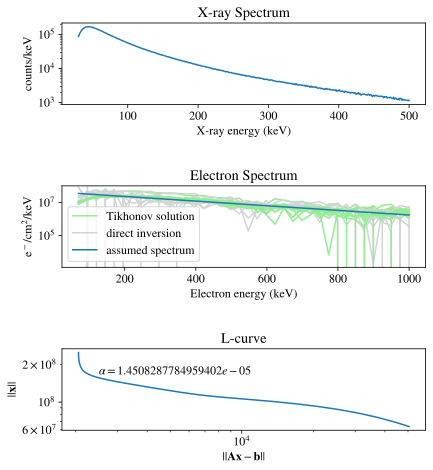

In [9]:
error = []
bias = []
k = []

x, e = ex(300,0,1000,1e10)

for kappa in np.logspace(-10,-3,100):
    sol, es, b = tk(R,L0,kappa,x,False)
    error.append(es)
    bias.append(b)
    k.append(kappa)

sol = tk(R,L0,2e-5,x,False)[0]

fig = plt.figure(figsize=(6.52437527778,7.5))
gs = plt.GridSpec(nrows=3, ncols=1,hspace=1.0,wspace=1.54)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

ax1.semilogy(xspace, x)
ax1.set_title('X-ray Spectrum')
ax1.set_ylabel('counts/keV')
ax2.set_ylabel('$\mathrm{e^-}/\mathrm{cm}^2/\mathrm{keV}$')
ax2.set_title('Electron Spectrum')



ax2.plot(espace, sol, label='Tikhonov solution', color='lightgreen')

for i in range(1,10):
    x, e = ex(300,0,1000,1e10)
    ax2.plot(espace, np.matmul(np.linalg.pinv(R), x/2),color='lightgrey')
    
for i in range(1,10):
    x, e = ex(300,0,1000,1e10)
    sol = tk(R,L0,2e-5,x,False)[0]
    ax2.plot(espace,sol/2, color='lightgreen')

ax2.semilogy(espace,sol, label='direct inversion', color='lightgrey')


ax2.semilogy(espace,e, label='assumed spectrum')


ax2.set_ylim([-1e3,1e8])

ax1.set_xlabel('X-ray energy (keV)')
ax2.set_xlabel('Electron energy (keV)')
ax3.set_title('L-curve')
ax3.loglog(error, bias)
ax3.set_ylabel('$||\mathbf{x} ||$')
ax3.set_xlabel('$||\mathbf{A}\mathbf{x} - \mathbf{b}||$')
ax3.annotate('$\\alpha = '+str(k[73])+'$', (error[73],bias[73]), textcoords='offset points', xytext=(10,0))
ax2.legend()
plt.savefig('L_curve_example.pdf')  
plt.show()